In [ ]:
#| default_exp hwc_2node

In [ ]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from fastcore.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In order to simulate aleternative control strategies a hot water cylinder environment that approximates the operation under real world conditions is required. There are a large number of models of varying numerical complexity that were reviewed such as:

[Model Predictive Control of Heat Pump Water Heaters for Energy Efficiency](https://www.aceee.org/files/proceedings/2014/data/papers/1-296.pdf)

[Dynamic modeling of a sensible thermal energy storage tank with an
immersed coil heat exchanger under three operation modes](https://engineering.purdue.edu/JainResearchLab/pdf/dynamic-modeling-sensible-thermal-energy-storage-immersed-coil-heat-exchanger.pdf)

These models have been developed to incorporate stratification and internal heat transfer however a simple energy balance model was selected with the addition of an internal conduction variable to decay the stratified layer.

[A minimal simulation of the electricity demand of a domestic hot water
cylinder for smart control](https://sci-hub.se/10.1016/j.apenergy.2017.11.044)
 

\section{Nomenclature}

$\Delta \quad$ internal heat transfer scaling parameter

$\dot{m}_{c} \quad$ mass flow rate of IHX coil fluid

$\dot{m}_{c w} \quad$ mass flow rate of inlet domestic cold water

$\dot{m}_{t} \quad$ discharge mass flow rate through tank

$\dot{Q}_{\text {coil }} \quad$ heat transfer rate due to IHX coil

$\dot{Q}_{j+1}$ heat transfer rate between nodes $j$ and $j+1$

$\dot{Q}_{j-1} \quad$ heat transfer rate between nodes $j$ and $j-1$

$\dot{Q}_{\text {wall }}$ heat transfer rate for losses to surroundings

A cross-sectional area of node control volume

$A_{w} \quad$ wall contact surface area

$c_{v} \quad$ specific heat capacity of water

$j \quad$ current node in iterative energy equations

$j+1 \quad$ represents node below node $j$

$\begin{array}{ll}j-1 & \text { represents node above node } j \\ k & \text { internal node interaction heat transfer coefficient } \\ k_{w} & \text { lumped heat transfer coefficient for losses across walls } \\ m & \text { mass of node } \\ s_{1} & \text { discharge fluid correction factor } \\ T & \text { temperature } \\ t & \text { time } \\ T_{c w} & \text { domestic cold water temperature } \\ T_{e n} & \text { IHX coil fluid inlet temperature } \\ T_{e x} & \text { IHX coil fluid outlet temperature } \\ w_{t} & \text { tank wall thickness } \\ z & \text { vertical height variable with respect to tank bottom }\end{array}$

In [29]:
#| export
class HWC():
  """
  Model of a Hot Water Cylinder using a nodal approach.
  """
  def __init__(self,
              element = 3,        # kW
              T_set = 75,         # °C
              T_deadband = 2,     # °C
              T_cold = 15,     # °C
              T_inlet = 15,     # °C
              radius =.25,        # m
              height = 1.1,       # m
              K = 0.05,       # m
              U = 0.8,
              noisey = True):
    super(HWC, self).__init__()
    self.U = U/60 #0.0019678 #U/60     # 0.5-0.8 kJ/min m2K typical heat transfer losses to ambient  [0.5 kJ/min m2K Jack Paper] kW/m2K
    self.split = np.array([2/3,1/3])
    self.Cv = 4.184 #kJ/kgK
    self.ρ = 1000 #kg/m3
    self.T_ambient = 15 #  Air temperature that the cylinder located in °C
    self.T_cold = T_cold # Make up water temperature °C to mixer
    self.T_inlet = T_inlet # Make up water temperature °C
    self.T_demand = 45 #T_demand - temperature of the end use (shower)  °C
    self.T_deadband = T_deadband #T_deadband  - thermostat deadband °C
    self.T_set = T_set #T_set - thermostat set point °C
    self.element = element # kW = kJ/s
    self.radius = radius
    self.height = height
    self.T_set_bu = 60
    self.flow = 0
    self.z = self.z_init
    self.K = K
    temperature = self.T_set + np.random.uniform(-5, 0)
    if noisey:
      self.temperatures = np.array([temperature,temperature+ np.random.uniform(-5, 0)])
    else:
      self.temperatures = np.array([self.T_set -1.0, self.T_set-4.0])
    self.thermostat = np.array([0,0]) # bulk / nodal high / nodal low

    self.temperatures_ = self.temperatures
    self.stratified = True
    # self._thermostat()
    
  @property
  def volume(self): return np.pi * self.radius ** 2 * self.height  # m3

  @property
  def A(self): return np.pi * self.radius**2 # m2 

  @property
  def cylinder_wall_area(self): return 2* np.pi * self.radius * self.height  # m2 

  @property
  def surface_area(self): return self.cylinder_wall_area + 2 * self.A # m2 

  @property
  def U_ends(self): 
    return self.U * self.A   / (self.Cv * self.volume * self.ρ)# unit  heat transfer coefficient kW/K
  
  @property
  def U_cylinder(self): 
    return self.U * self.cylinder_wall_area  / (self.Cv * self.volume * self.ρ) # unit  heat transfer coefficient kW/K  
  
  @property
  def z_init(self): 
    return .7  # initial thermocline level from the top of the cylinder

  @property
  def temperature(self): 
    if not self.stratified:
      return self.temperatures[0]
    else:
      return self.temperatures[0]*self.z + self.temperatures[1]*(1-self.z)


![HWC](images/hwc.png)

In [6]:
#| export
@patch
def _update_model(self:HWC, action = 0, flow = 0, timestep = 60): 
    # the demand flow is at the temperature of the end use (shower) °C after the themostatic mixing valve and this requires adjustment to compenstate for the outlet temperature of the cylinder
    tempered_flow = (flow*(self.T_demand-self.T_cold) /(self.temperatures[0]-self.T_cold).clip(min=0))

    f_t = tempered_flow / self.volume
    q_t = action * self.element * timestep / (self.Cv * self.volume * self.ρ)
    if self.stratified:
        self.temperatures[0] += -((self.U_ends + self.U_cylinder * self.z) * (self.temperatures[0] - self.T_ambient) + self.K * self.A) /self.z
        self.temperatures[1] += (f_t * (self.T_inlet - self.temperatures[1]) + \
                                q_t - \
                                (self.U_ends + self.U_cylinder * (1-self.z))*(self.temperatures[1] - self.T_ambient)+ self.K * self.A) /(1-self.z)
        self.z -= f_t
    else: 
        self.temperatures[0] += (f_t *(self.T_inlet - self.temperatures.mean()) + \
                                q_t - \
                               (2*self.U_ends + self.U_cylinder)*(self.temperatures.mean() - self.T_ambient))
        self.temperatures[1] = self.temperatures[0]
    # test for change in state
    if (self.flow == 0) and (flow > 0): # change to state (ii) i.e. from fully mixed to stratified
        self.z = self.z_init
        self.stratified = True
    
    if (self.temperatures[1]>self.temperatures[0]) or self.z <=0 or self.z >=1:
        self.stratified = False
        self.temperatures[0] = self.temperatures[0]* self.z + self.temperatures[1] * (1-self.z) 
        self.temperatures[1] = self.temperatures[0]


In [7]:

env = HWC(T_set=55, element=3)
temp = []
for step in range(60):
    env._update_model(action = 1, flow = 0)
    # temp0.append(env.temperatures[0])    
    temp.append(env.temperatures.copy())
    # print(env.temperatures, env.z, env.stratified)
# env.step(flow=0.03)
# print(env.temperatures, env.z, env.stratified)
# env.step(action=1,flow=0)
# print(env.temperatures, env.z, env.stratified)
# env.step(action=1)
# print(env.temperatures, env.z, env.stratified)

In [8]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(wall_losses)
print(f'Expected temperature rise = {expected_temp_rise:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

0.06906025375628055
Expected temperature rise = 12.0
Model temperature change = 11.9°C


In [9]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cv) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(f'Expected temperature rise = {expected_temp_rise-wall_losses:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

Expected temperature rise = 11.9
Model temperature change = 11.9°C


# Model Operation

## Initialisation

Text(0.5, 0.98, 'Random initial states of charge for 10 different models')

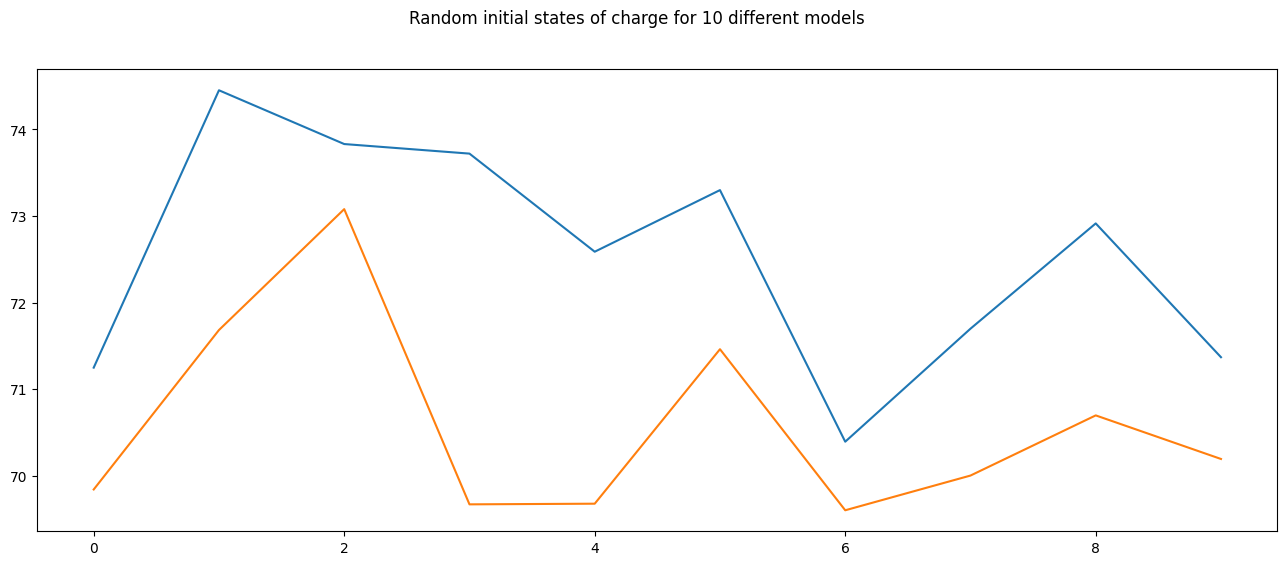

In [10]:
temp = []
for i in range(10):
    env = HWC(T_set=75, element=3)
    temp.append(env.temperatures)
    assert env.temperatures[0]<= 75.5
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('Random initial states of charge for 10 different models')

In [11]:
env = HWC(T_set=75, element=3, height=1, radius=.5)
# check that the volume and areas are correct
assert env.volume == np.pi/4
assert env.A == np.pi/4

## Passive Losses - No Heating + No Flow

In [14]:
env = HWC(T_set=55, element=3, radius=.25, U=.8)
temp = []
minutes = 60*24
for minute in range(minutes):
    env._update_model(action = 0 , flow = 0)
    temp.append(env.temperatures.copy())

### Compare to calulation from first principles

In [19]:
mean_cylinder_temperature = (np.vstack(temp)* env.split).sum(axis=1).mean()
passive_real =   env.U * env.surface_area * (mean_cylinder_temperature - env.T_ambient) # kW/m2K x m2 x K  = KW
passive_real =   passive_real * 60 * 24 / 1000 # kWh per day

model_losses =   env.volume * env.ρ * env.Cv * ((temp[0]* env.split).sum()- (temp[-1]* env.split).sum()) / 1000 
print(f'Calculated Passive losses: {passive_real/24:.2f} kWh / hour and a total of {passive_real:.2f} kWh / day')

print(f'Model Losses:  minutes {model_losses/24:.2f} kWh / hour and a total of {model_losses:.2f} kWh / day')



Calculated Passive losses: 0.09 kWh / hour and a total of 2.19 kWh / day
Model Losses:  minutes 0.09 kWh / hour and a total of 2.10 kWh / day


In [20]:
env = HWC(T_set=75, element=3, radius=.25, U=.8)
temp = []
minutes = 60*24
for minute in range(minutes):
    env._update_model(action = 0 , flow = 0)
    temp.append(env.temperatures.copy())

In [21]:
mean_cylinder_temperature = (np.vstack(temp)* env.split).sum(axis=1).mean()
passive_real =   env.U * env.surface_area * (mean_cylinder_temperature - env.T_ambient) # kW/m2K x m2 x K  = KW
passive_real =   passive_real * 60 * 24 / 1000 # kWh per day

model_losses =   env.volume * env.ρ * env.Cv * ((temp[0]* env.split).sum()- (temp[-1]* env.split).sum()) / 1000 
print(f'Calculated Passive losses: {passive_real/24:.2f} kWh / hour and a total of {passive_real:.2f} kWh / day')

print(f'Model Losses:  minutes {model_losses/24:.2f} kWh / hour and a total of {model_losses:.2f} kWh / day')

Calculated Passive losses: 0.09 kWh / hour and a total of 2.23 kWh / day
Model Losses:  minutes 0.09 kWh / hour and a total of 2.19 kWh / day


Text(0.5, 0.98, 'Passive Losses - No Heating + No Flow over 1440 minutes')

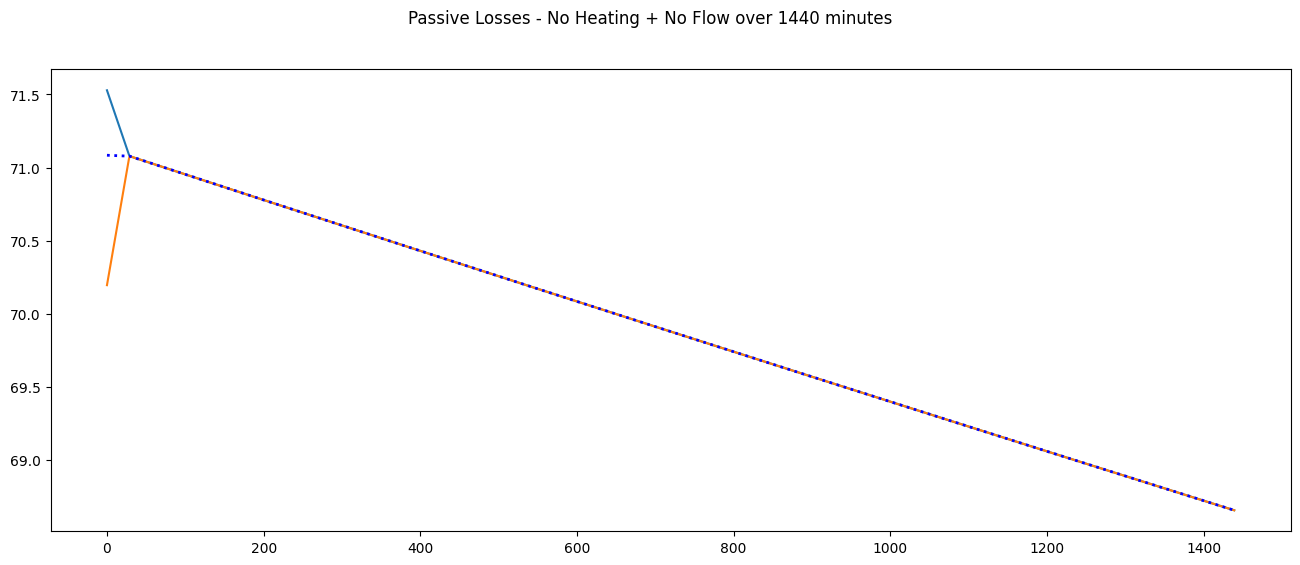

In [22]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot((np.vstack(temp)*env.split).sum(axis=1), lw=2, ls=':', c='blue')
fig.suptitle(f'Passive Losses - No Heating + No Flow over {minutes} minutes') 

The standing heat loss for a tank should be in the order of 1.7 kWh / day for a tank at 55 degrees. https://sustainableengineering.co.nz/portfolio-item/dhw-tanks-w-k-from-kwh-day/

## No Heating + Flow rate of 10 litres per minure for 10 minutes

Text(0.5, 0.98, 'No Heating + Flow rate of 10 litres per minure for 10 minutes')

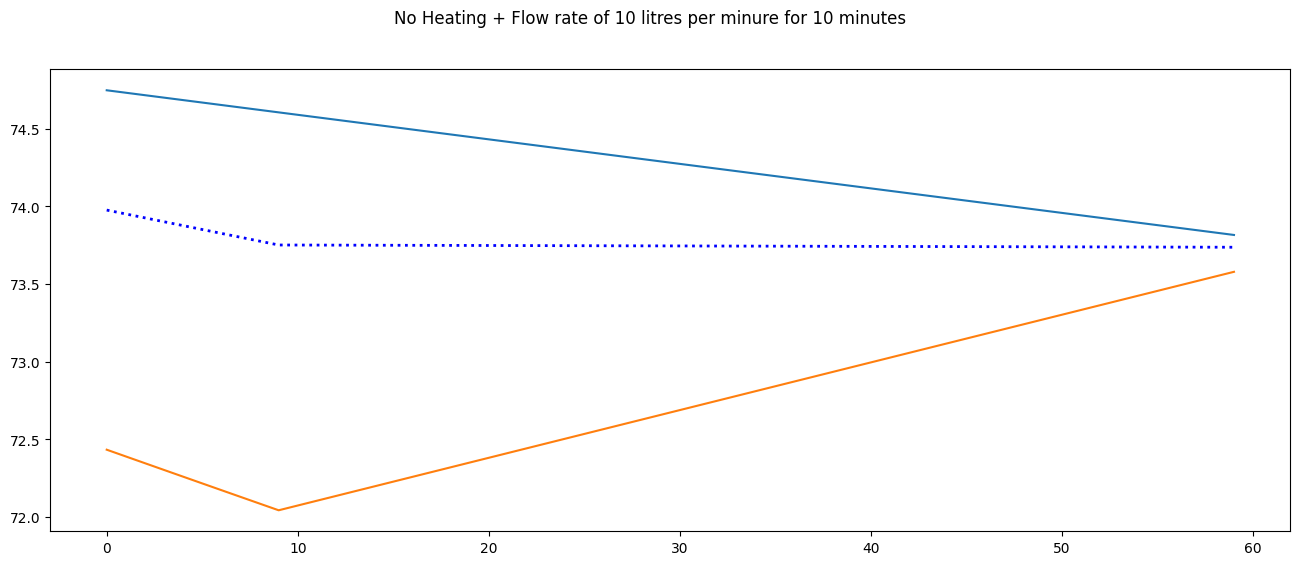

In [23]:
env = HWC(T_set=75, element=3)
flow = 10/60/1000 # 10 litres per minute
temp = []
minutes = 60
for minute in range(minutes):
    action = 0 #np.random.randint(0,2)
    env._update_model(action = action , flow = flow if minute < 10 else 0)
    temp.append(env.temperatures.copy())

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot((np.vstack(temp)*env.split).sum(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('No Heating + Flow rate of 10 litres per minure for 10 minutes')

# Heating Bottom Element + No Flow

Text(0.5, 0.98, 'dd')

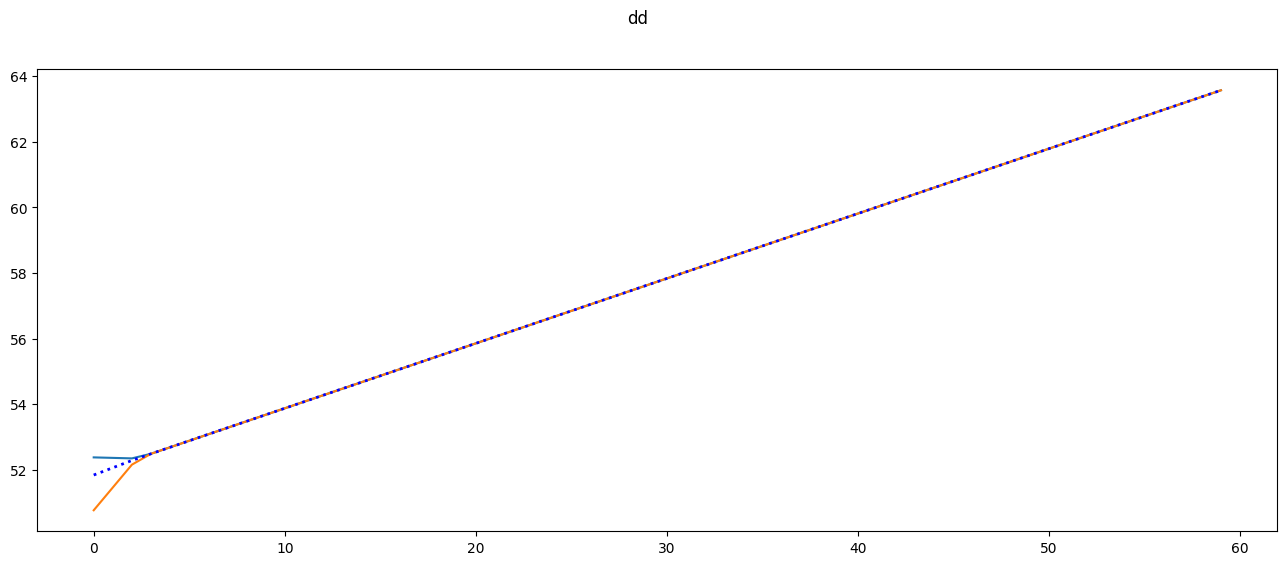

In [24]:
env = HWC(T_set=55, element=3)
temp = []
minutes = 60
for minute in range(minutes):
    env._update_model(action = 1 , flow = 0)
    temp.append(env.temperatures.copy())

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot((np.vstack(temp)*env.split).sum(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('dd')

In [25]:
# In 1 hour
Tfinal = 3600 * env.element / (env.volume * env.ρ * env.Cv) + temp[0].mean()
print(f'Expected temperature rise = {Tfinal:.1f}')
print(f'Model final temperature = {(temp[-1]*env.split).sum():.1f}°C')

Expected temperature rise = 63.5
Model final temperature = 63.6°C


In [27]:
#| hide
import nbdev; nbdev.nbdev_export()